# MinMaxScaler

In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
jar = pd.read_csv('clean_data.csv')

fdVals = jar['FD'].unique()

hi_fd = jar[jar['FD'] == fdVals[-1]]
hi_fd = hi_fd.drop(['FD', 'fuel_gas_swelling'], axis=1)

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
feat_ind = list(range(3))
features = hi_fd.iloc[:, feat_ind]
xscaler = MinMaxScaler()
X = xscaler.fit_transform(features)
y = hi_fd['fuel_swelling']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17
)

# Convenience functions

In [6]:
def lin_coef_cept(mod):
    print(
        ' coeffs: ',
        mod.coef_, '\n',
        'intercept: ',
        mod.intercept_
    )

In [7]:
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

def mod_metrics(mod, X_test, y_test):
    y_pred = mod.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(
        ' R2: ', r2, '\n',
        'RMSE: ', rmse, '\n',
        'MAE: ', mae
    )

In [8]:
def pred_vs_actual(mod, X_test, y_test, tt):
    y_pred = mod.predict(X_test)

    plt.figure(figsize=(5,4))
    plt.rcParams.update({'font.size': 16})
    
    plt.scatter(y_test, y_pred, s=15)
    plt.plot(list(range(30, 70)), list(range(30, 70)),
            color='k', ls='--', label='y=x')

    plt.title(tt)
    plt.xlabel(r'Test data (swelling \%)')
    plt.ylabel(r'Surrogate pred. (swelling \%)')
    plt.legend()
    plt.show()

# Lasso

In [9]:
from sklearn import linear_model

 coeffs:  [ 32.95486762 -11.42921488  -3.50783771] 
 intercept:  44.58343910842427
 R2:  0.997059056178078 
 RMSE:  0.2545609841210499 
 MAE:  0.1744199194559234


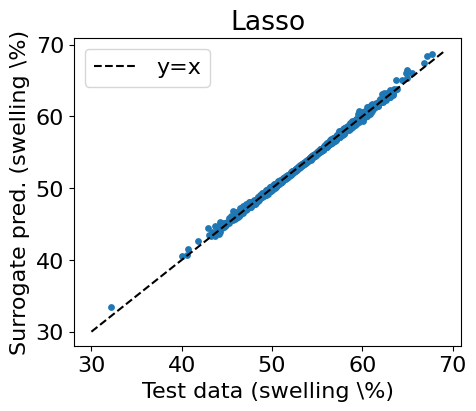

In [10]:
reg_las3 = linear_model.Lasso(
        alpha=0.0039, random_state=42
    ).fit(X_train, y_train)

#print(' alpha: ', reg_las3.alpha_)
lin_coef_cept(reg_las3)
mod_metrics(reg_las3, X_test, y_test)
pred_vs_actual(reg_las3, X_test, y_test, 'Lasso')

# GP

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

In [12]:
tX_train, _, ty_train, _ = train_test_split(
    X_train, y_train, test_size=0.8, random_state=17
)

In [13]:
kern = 1.0*RBF()
reg_gp = GaussianProcessRegressor(
    kernel=kern,
    alpha=1e-3,
    n_restarts_optimizer=9,
    random_state=42
)
reg_gp.fit(tX_train, ty_train)

/home/atom/research/wd-swelling/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(alpha=0.001, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=9, random_state=42)

In [14]:
reg_gp.kernel_

61.9**2 * RBF(length_scale=2.96)

 R2:  0.9998059500697227 
 RMSE:  0.06538907930837554 
 MAE:  0.04359685598332134


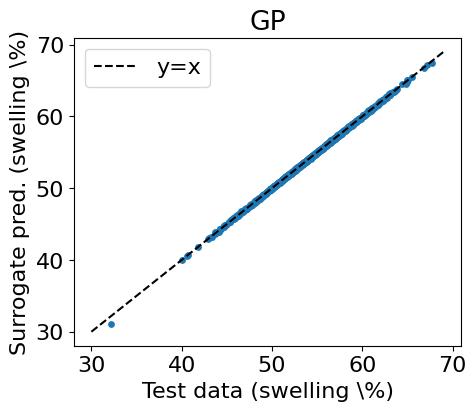

In [15]:
mod_metrics(reg_gp, X_test[:, :3], y_test)
pred_vs_actual(reg_gp, X_test[:, :3], y_test, 'GP')

# Load MCMC samples

In [16]:
smpl1 = np.load('smpl1.npy')
smpl2 = np.load('smpl2.npy')

orig1 = xscaler.inverse_transform(smpl1)
orig2 = xscaler.inverse_transform(smpl2)

jsmpl = np.concatenate((smpl1[::100], smpl2[::100]))
jorig = np.concatenate((orig1[::100], orig2[::100]))

# IUQ

In [17]:
rcupd = {
    'figure.figsize': (5, 4),
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': 'cm',
    'font.size': 12,
}
plt.rcParams.update(rcupd)

<Figure size 1000x800 with 0 Axes>

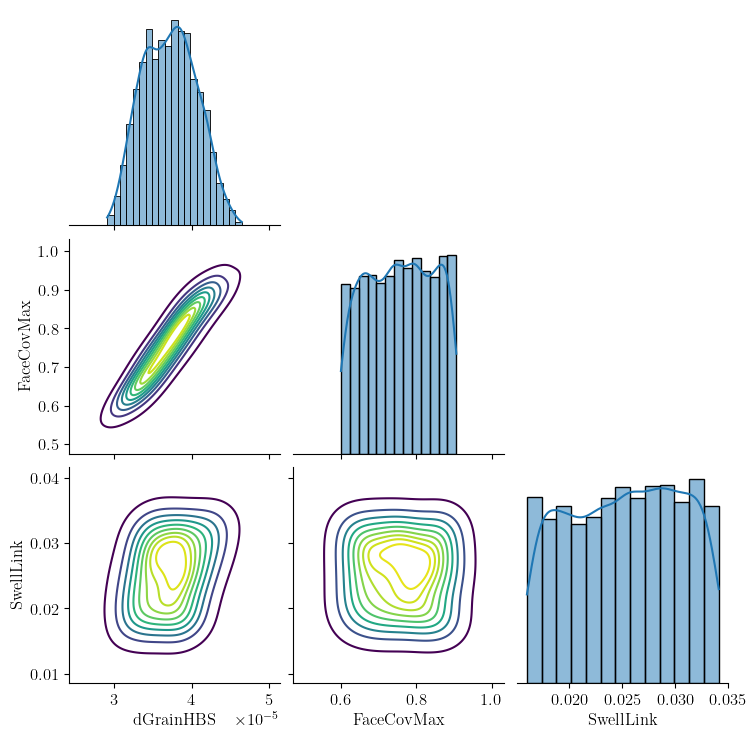

In [18]:
dforig = pd.DataFrame(jorig, columns=['dGrainHBS', 'FaceCovMax', 'SwellLink'])

plt.figure(figsize=(10, 8))
sns.pairplot(
    dforig,
    diag_kind='hist',
    diag_kws=dict(kde=True),
    plot_kws=dict(cmap='viridis', bw_adjust=1.7),
    kind='kde',
    corner=True
)

plt.show()

<Axes: >

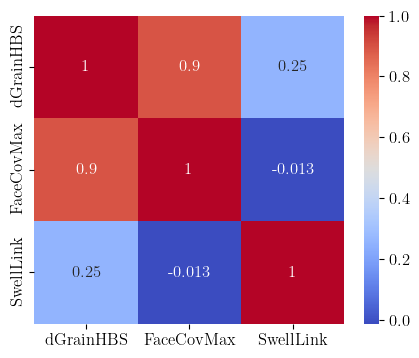

In [19]:
sns.heatmap(dforig.corr(), annot=True, cmap='coolwarm')

# Mean, dev, cred. interval

In [20]:
dforig.describe()

,dGrainHBS,FaceCovMax,SwellLink
count,2002.000000,2002.000000,2002.000000
mean,0.000037,0.757332,0.025285
std,0.000003,0.088211,0.005219
min,0.000029,0.600302,0.016020
25%,0.000034,0.679342,0.020718
50%,0.000037,0.756288,0.025464
75%,0.000040,0.833184,0.029713
max,0.000046,0.906452,0.034126


In [21]:
for i in range(3):
    print(np.mean(dforig.iloc[:, i]),
          np.std(dforig.iloc[:, i]))

3.7180413580954836e-05 3.42262691791727e-06
0.7573317078325144 0.08818861376285435
0.02528464978586465 0.00521813492779212


In [22]:
for i in range(3):
    print(np.percentile(dforig.iloc[:, i], 2.5),
          np.percentile(dforig.iloc[:, i], 97.5))

3.113581181608032e-05 4.371671314651349e-05
0.6086006811951147 0.8994896621031482
0.01658638321916072 0.03369261147393427


# Copulas

In [23]:
from copulas.multivariate import GaussianMultivariate

In [24]:
dfsmpl = pd.DataFrame(jsmpl, columns=['dGrainHBS', 'FaceCovMax', 'SwellLink'])

copula = GaussianMultivariate()
copula.fit(dfsmpl)

In [25]:
num_smpl = 2000

synth_df = copula.sample(num_smpl)
synth_df.head()

,dGrainHBS,FaceCovMax,SwellLink
0,0.484381,0.578495,0.373651
1,0.413068,0.563201,0.184906
2,0.292971,0.085366,0.905833
3,0.601484,0.925595,0.817068
4,0.392814,0.370638,0.945283


In [26]:
synth_np = synth_df.values
synth_orig = xscaler.inverse_transform(synth_np)

<Figure size 1000x800 with 0 Axes>

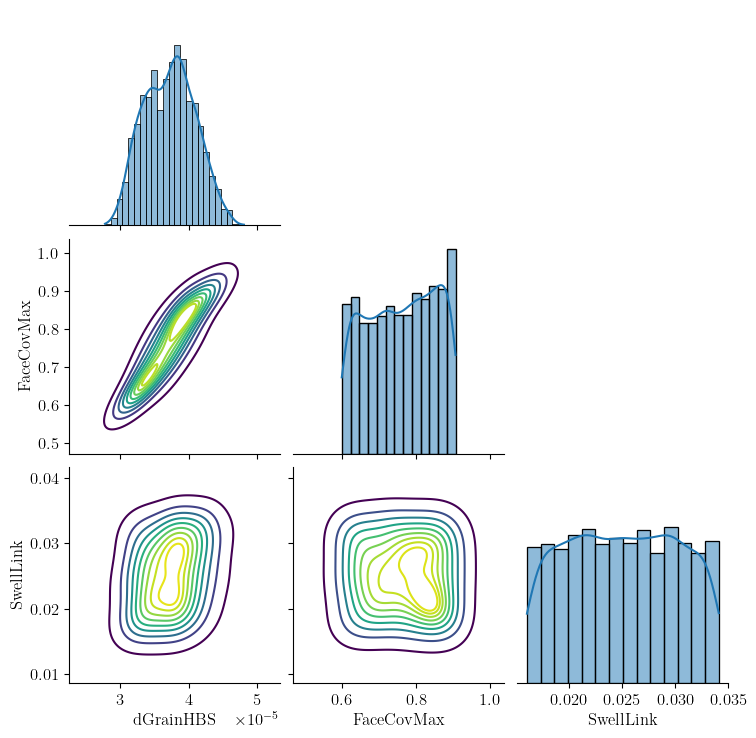

In [27]:
synth_orig_df = pd.DataFrame(synth_orig, columns=['dGrainHBS', 'FaceCovMax', 'SwellLink'])

plt.figure(figsize=(10, 8))
sns.pairplot(
    synth_orig_df,
    diag_kind='hist',
    diag_kws=dict(kde=True),
    plot_kws=dict(cmap='viridis', bw_adjust=1.7),
    kind='kde',
    corner=True
)

plt.show()

<Axes: >

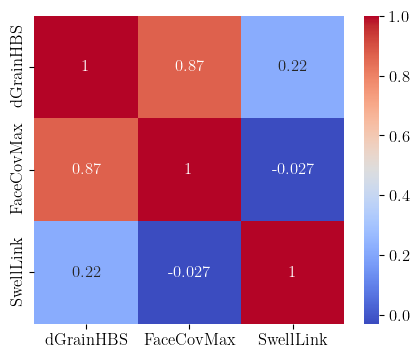

In [28]:
sns.heatmap(synth_orig_df.corr(), annot=True, cmap='coolwarm')

# FUQ with synthetic data

In [29]:
def swelling_perc(fd):
    #return 6.13e-43 * fd**2 + 4e-21 * fd
    return 3.83e-43 * fd**2 + 4.54e-21 * fd

def fuq(mod, samples):
    orig = []
    res = []
    for i in range(2000):
        res.append(mod.predict([samples[-i]])[0])
        c = np.random.normal(swelling_perc(7e21), 1.25)
        orig.append(c)
        
    plt.figure(figsize=(5, 4))
    sns.histplot(orig, kde=True, bins=30, ec='k', stat='density', label='Obs. with noise')
    sns.histplot(res, kde=True, bins=30, ec='k', stat='density', label='Forward propagation')
    
    plt.xlim([45, 60])
    plt.xlabel(r'Fuel Swelling (\%)')
    plt.legend(fontsize='x-small', loc='upper right')
    plt.show()

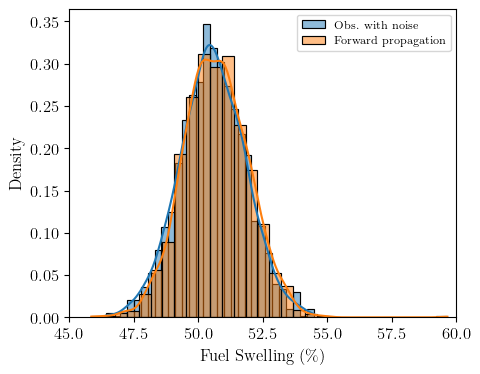

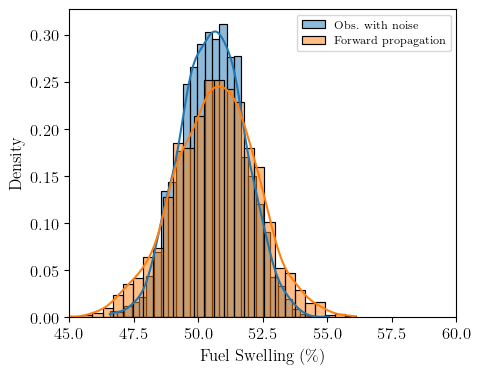

In [30]:
fuq(reg_las3, jsmpl)
fuq(reg_las3, synth_np)

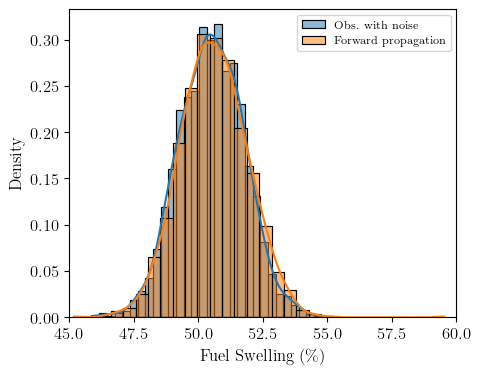

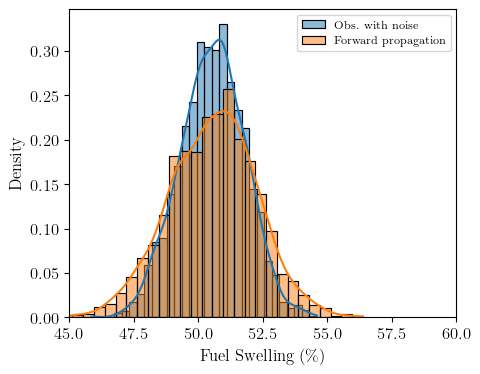

In [31]:
fuq(reg_gp, jsmpl)
fuq(reg_gp, synth_np)